迁移学习
---------------

实际中，基本没有人会从零开始（随机初始化）训练一个完整的卷积网络。
因为相对于网络，很难得到一个足够大的数据集【网络很深，需要足够大数据集】

通常的做法是在一个很大的数据集上进行预训练，得到卷积网络ConvNet，然后将这个卷积网络的参数
作为目标任务的初始化参数或者固定这些参数。

#### 迁移学习的两个主要场景：

- 微调Convnet：使用预训练的网络来初始化自己的网络，其他步骤不变
- 将Convnet看成固定的特征提取器： 首先固定Convnet上除了最后的全连接层之外的其他所有层。最后的全连接层会被替换成一个新的随机初始化的层。只有这个新的层会被用来训练【只有这层参数会在反向传播的时候更新】


举例：训练一个模型对蚂蚁和蜜蜂进行分类。

### 1. 导入相关的包

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

### 2.加载数据

ants和bees各有约120张训练图片。
每个类有75张验证图片。

从零开始在这么小的数据集上进行训练通常是很难泛化的。
我们使用迁移学习，模型的泛化能力会相当的好。

首先是下载数据集，然后将其解压到指定目录。

In [2]:
# 训练集数据扩充和归一化
# 验证集上仅需要归一化

data_transforms = {
    'train':transforms.Compose([
        transforms.RandomResizedCrop(224), # 随机裁减一个area之后再resize
        transforms.RandomHorizontalFlip(), # 随机水平反转
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
    'val' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 3. 可视化部分图象数据

以便了解数据扩充

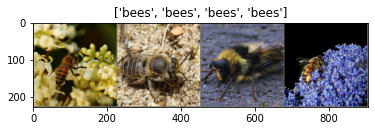

In [3]:
def imshow(inp, title=None):
    """imshow for Tensor"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
# 获取一批训练数据
inputs, classes = next(iter(dataloaders['train']))
# 批量制作网络
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### 4. 训练模型

编写一个通用函数来训练模型。

下面的参数scheduler是一个来自torch.optim.lr_scheduler的学习速率调整类的对象（LR scheduler object）

In [32]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch{}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)
        
        # 每个epoch都有一个训练和验证阶段
        for phase in ['train','val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # set model to training mode
            else:
                model.eval()  # set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0
            
            # 迭代数据
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # 参数梯度清零
                optimizer.zero_grad()
                
                # 前向
                # track history if only in train
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # 后向 + 仅在训练阶段进行优化
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # 统计
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{}Loss:{:4f} Acc:{:4f}'.format(phase, epoch_loss, epoch_acc))
            
            # 深度复制mo
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # 加载最佳模型权重
    model.load_state_dict(best_model_wts)
    return model

5.可视化模型的预测结果
-------------------

In [40]:
# 一个通用的展示少量预测图片的函数
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i,(inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted:{}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                
            model.train(mode=was_training)

6.场景1： 微调ConvNet
-----------------------

加载预训练模型，并充值最终完全连接的图层

In [33]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# 观察所有参数都正在优化
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 每7个epochs衰减LR通过设置gamma-0.1
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### 训练和评估模型

cpu上15-25分钟，在GPU上不到一分钟

In [34]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch0/24
----------
trainLoss:0.655037 Acc:0.692623
valLoss:0.318095 Acc:0.869281

Epoch1/24
----------
trainLoss:0.638474 Acc:0.737705
valLoss:0.262143 Acc:0.895425

Epoch2/24
----------
trainLoss:0.441651 Acc:0.844262
valLoss:0.248924 Acc:0.888889

Epoch3/24
----------
trainLoss:0.433455 Acc:0.795082
valLoss:0.307276 Acc:0.869281

Epoch4/24
----------
trainLoss:0.463667 Acc:0.807377
valLoss:0.249351 Acc:0.928105

Epoch5/24
----------
trainLoss:0.566905 Acc:0.770492
valLoss:0.333143 Acc:0.862745

Epoch6/24
----------
trainLoss:0.368870 Acc:0.852459
valLoss:0.221808 Acc:0.934641

Epoch7/24
----------
trainLoss:0.367904 Acc:0.848361
valLoss:0.222947 Acc:0.928105

Epoch8/24
----------
trainLoss:0.312243 Acc:0.885246
valLoss:0.231329 Acc:0.928105

Epoch9/24
----------
trainLoss:0.334676 Acc:0.877049
valLoss:0.219244 Acc:0.934641

Epoch10/24
----------
trainLoss:0.301697 Acc:0.868852
valLoss:0.228816 Acc:0.928105

Epoch11/24
----------
trainLoss:0.258382 Acc:0.905738
valLoss:0.223730 Acc:

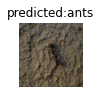

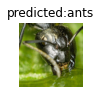

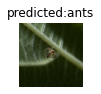

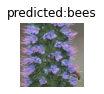

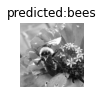

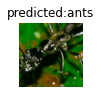

In [41]:
### 模型评估效果可视化

visualize_model(model_ft)

### 7. 场景2：ConvNet作为固定的特征提取器

这里需要冻结除了最后一层之外的所有网络。
需要设置requires_grad = Falsebackward()来冻结参数
这样在反向传播的时候，他们的梯度不会被计算。

In [43]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
# Parameters of newly constructed modules have requires_grad = True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

训练和评估
------------------

训练模型在CPU上，和之前场景相比，这将花费大约一般的时间，因为不需要大多数的网络计算梯度。但是需要计算转发。

In [44]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch0/24
----------
trainLoss:0.542889 Acc:0.704918
valLoss:0.215020 Acc:0.928105

Epoch1/24
----------
trainLoss:0.384174 Acc:0.815574
valLoss:0.452134 Acc:0.823529

Epoch2/24
----------
trainLoss:0.509723 Acc:0.786885
valLoss:0.226115 Acc:0.928105

Epoch3/24
----------
trainLoss:0.475033 Acc:0.770492
valLoss:0.209352 Acc:0.954248

Epoch4/24
----------
trainLoss:0.549477 Acc:0.795082
valLoss:0.300006 Acc:0.882353

Epoch5/24
----------
trainLoss:0.484240 Acc:0.786885
valLoss:0.177332 Acc:0.960784

Epoch6/24
----------
trainLoss:0.340041 Acc:0.872951
valLoss:0.178736 Acc:0.954248

Epoch7/24
----------
trainLoss:0.282793 Acc:0.881148
valLoss:0.178523 Acc:0.954248

Epoch8/24
----------
trainLoss:0.393094 Acc:0.827869
valLoss:0.170419 Acc:0.960784

Epoch9/24
----------
trainLoss:0.366907 Acc:0.827869
valLoss:0.192341 Acc:0.947712

Epoch10/24
----------
trainLoss:0.375589 Acc:0.831967
valLoss:0.222413 Acc:0.908497

Epoch11/24
----------
trainLoss:0.335615 Acc:0.860656
valLoss:0.209286 Acc:

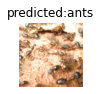

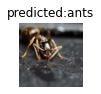

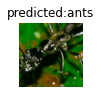

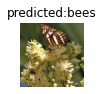

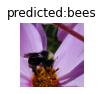

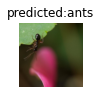

In [45]:
visualize_model(model_conv)

plt.ioff()
plt.show()